In [ ]:
import cv2
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMG_SIZE = 256
train_dir = '/content/drive/MyDrive/COVID/train/'
test_dir = '/content/drive/MyDrive/COVID/test/'

X_train = []
y_train = []

for folder in os.scandir(train_dir):
    count = 0  # Initialize count to 0
    for entry in os.scandir(train_dir + folder.name):
        img = cv2.imread(train_dir + folder.name + '/' + entry.name, cv2.IMREAD_COLOR)  # Read image using OpenCV
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize image to specified size
        img = np.array(img, dtype='float32')  # Convert image to float32 type
        img = img/255  # Normalize pixel values to range [0, 1]

        X_train.append(img)  # Append image to training data

        count += 1  # Increment count for each image

        if folder.name == 'Abnormal':
            y_train.append(0)  # Assign class label 0 for 'Abnormal'
        elif folder.name == 'Normal':
            y_train.append(1)  # Assign class label 1 for 'Normal'

    print(f"Folder: {folder.name}, Total Training Images: {count}")

X_train = np.array(X_train)  # Convert training data to numpy array
y_train = np.array(y_train)  # Convert class labels to numpy array

X_aug = []
y_aug = []

datagen = ImageDataGenerator(horizontal_flip=True)  # Data augmentation: horizontal flip

# Generate augmented data
augmented_data = datagen.flow(X_train, y_train, batch_size=32, shuffle=False)

# Concatenate the original training data with the augmented data
X_aug = np.concatenate([X_train, augmented_data[0][0]], axis=0)  # Concatenate augmented images along axis 0
y_aug = np.concatenate([y_train, augmented_data[0][1]], axis=0)  # Concatenate augmented class labels along axis 0


Folder: Normal, Total Training Images: 80
Folder: Abnormal, Total Training Images: 181


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle=True, stratify=y_train, random_state=123)

model = tf.keras.Sequential([
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

opt = optimizers.Adam(learning_rate=0.0001)

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

checkpointer = ModelCheckpoint(filepath="main.h5", verbose=1, save_best_only=True)

history = model.fit(X_aug, y_aug, epochs=100, validation_data=(X_val, y_val), batch_size=32, shuffle=True, callbacks=[checkpointer])


Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.7569 - accuracy: 0.5870
Epoch 1: val_loss improved from inf to 0.65411, saving model to main.h5
10/10 [==============================] - 44s 4s/step - loss: 0.7569 - accuracy: 0.5870 - val_loss: 0.6541 - val_accuracy: 0.7000
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - ETA: 0s - loss: 0.6527 - accuracy: 0.6485
Epoch 2: val_loss did not improve from 0.65411
10/10 [==============================] - 42s 4s/step - loss: 0.6527 - accuracy: 0.6485 - val_loss: 0.7098 - val_accuracy: 0.7000
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.5584 - accuracy: 0.6928
Epoch 3: val_loss improved from 0.65411 to 0.58302, saving model to main.h5
10/10 [==============================] - 40s 4s/step - loss: 0.5584 - accuracy: 0.6928 - val_loss: 0.5830 - val_accuracy: 0.7250
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.4654 - accuracy: 0.7782
Epoch 4: val_loss improved from 0.58302 to 0.49121, saving model to main.h5
10/10 [==============================] - 40s 4s/step - loss: 0.4654 - accuracy: 0.7782 - val_loss: 0.4912 - val_accuracy: 0.7500
Epoch 5/100
10/10 [==============================] - ETA: 0s - loss: 0.4619 - accuracy: 0.7679
Epoch 5: val_loss improved from 0.49121 to 0.4

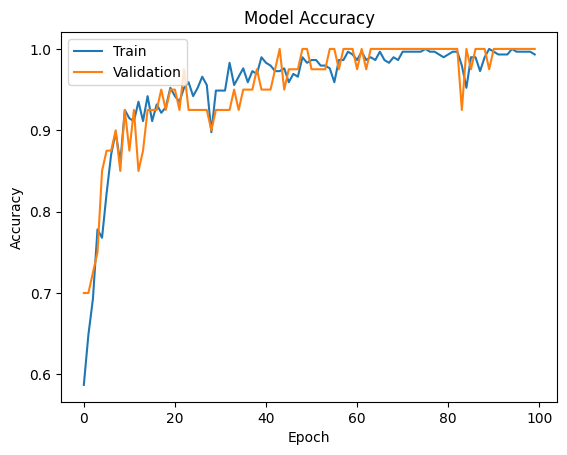

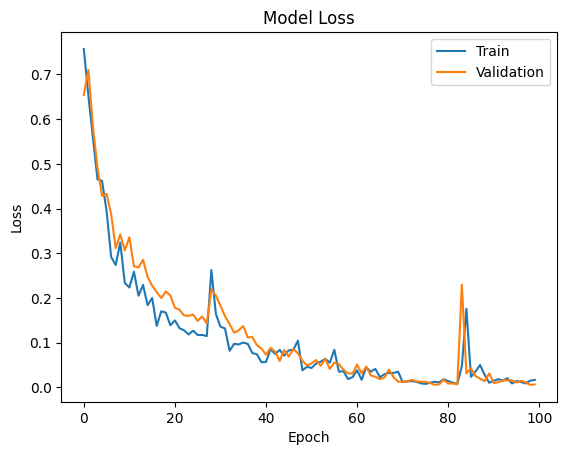

In [ ]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
X_test = []
y_test = []

for folder in os.scandir(test_dir):
    for entry in os.scandir(test_dir + folder.name):
        img = cv2.imread(test_dir + folder.name + '/' + entry.name, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = np.array(img, dtype='float32')
        img = img / 255

        X_test.append(img)

        if folder.name == 'Abnormal':
            y_test.append(0)
        elif folder.name == 'Normal':
            y_test.append(1)

X_test = np.array(X_test)
y_test = np.array(y_test)

model.load_weights("main.h5")

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test, batch_size=32)
print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)


3/3 [==============================] - 2s 545ms/step - loss: 0.1558 - accuracy: 0.9394
Test Loss:  0.15583060681819916
Test Accuracy:  0.939393937587738


In [ ]:
from sklearn.metrics import classification_report
# Generate classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
class_names = ['Abnormal','Normal']  # Replace with your class names
report = classification_report(y_test, y_pred_classes, target_names=class_names)
print(report)

3/3 [==============================] - 3s 1s/step
              precision    recall  f1-score   support

    Abnormal       0.94      0.98      0.96        46
      Normal       0.94      0.85      0.89        20

    accuracy                           0.94        66
   macro avg       0.94      0.91      0.93        66
weighted avg       0.94      0.94      0.94        66



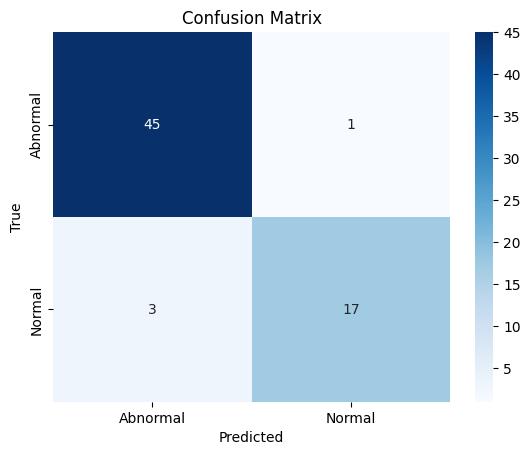

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

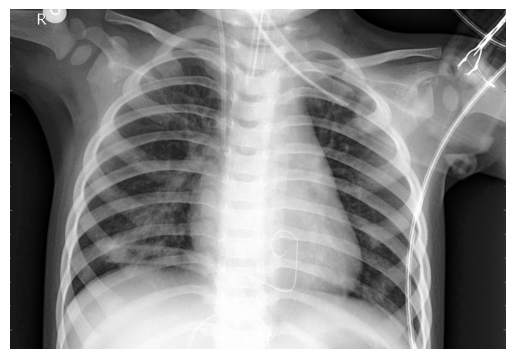

1/1 [==============================] - 0s 89ms/step
True Class: Abnormal
Predicted Class: Abnormal


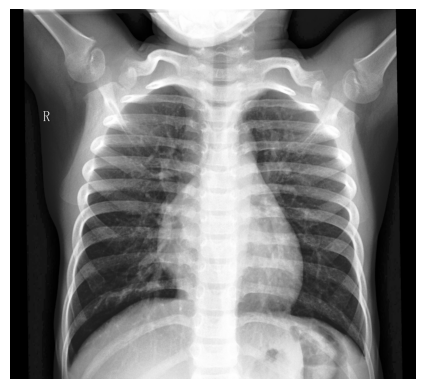

1/1 [==============================] - 0s 51ms/step
True Class: Normal
Predicted Class: Normal


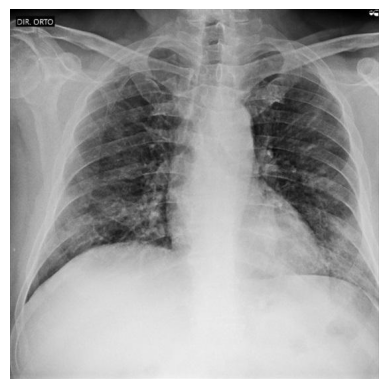

1/1 [==============================] - 0s 52ms/step
True Class: Abnormal
Predicted Class: Abnormal


In [ ]:
import random

# Randomly display 3 images from test folders
for i in range(3):
    folder_name = random.choice(['Abnormal','Normal'])
    image_name = random.choice(os.listdir(test_dir + folder_name))
    image_path = os.path.join(test_dir, folder_name, image_name)

    # Load and display the selected image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Preprocess the image for prediction
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = np.array(image, dtype='float32')
    image = image / 255
    image = np.expand_dims(image, axis=0)

    # Make predictions using the model
    predictions = model.predict(image)
    predicted_class_index = np.argmax(predictions, axis=1)
    predicted_class_name = class_names[predicted_class_index[0]]

    # Print true class and predicted class
    print('True Class:', folder_name)
    print('Predicted Class:', predicted_class_name)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the tflite model to a file
with open('main.tflite', 'wb') as f:
    f.write(tflite_model)

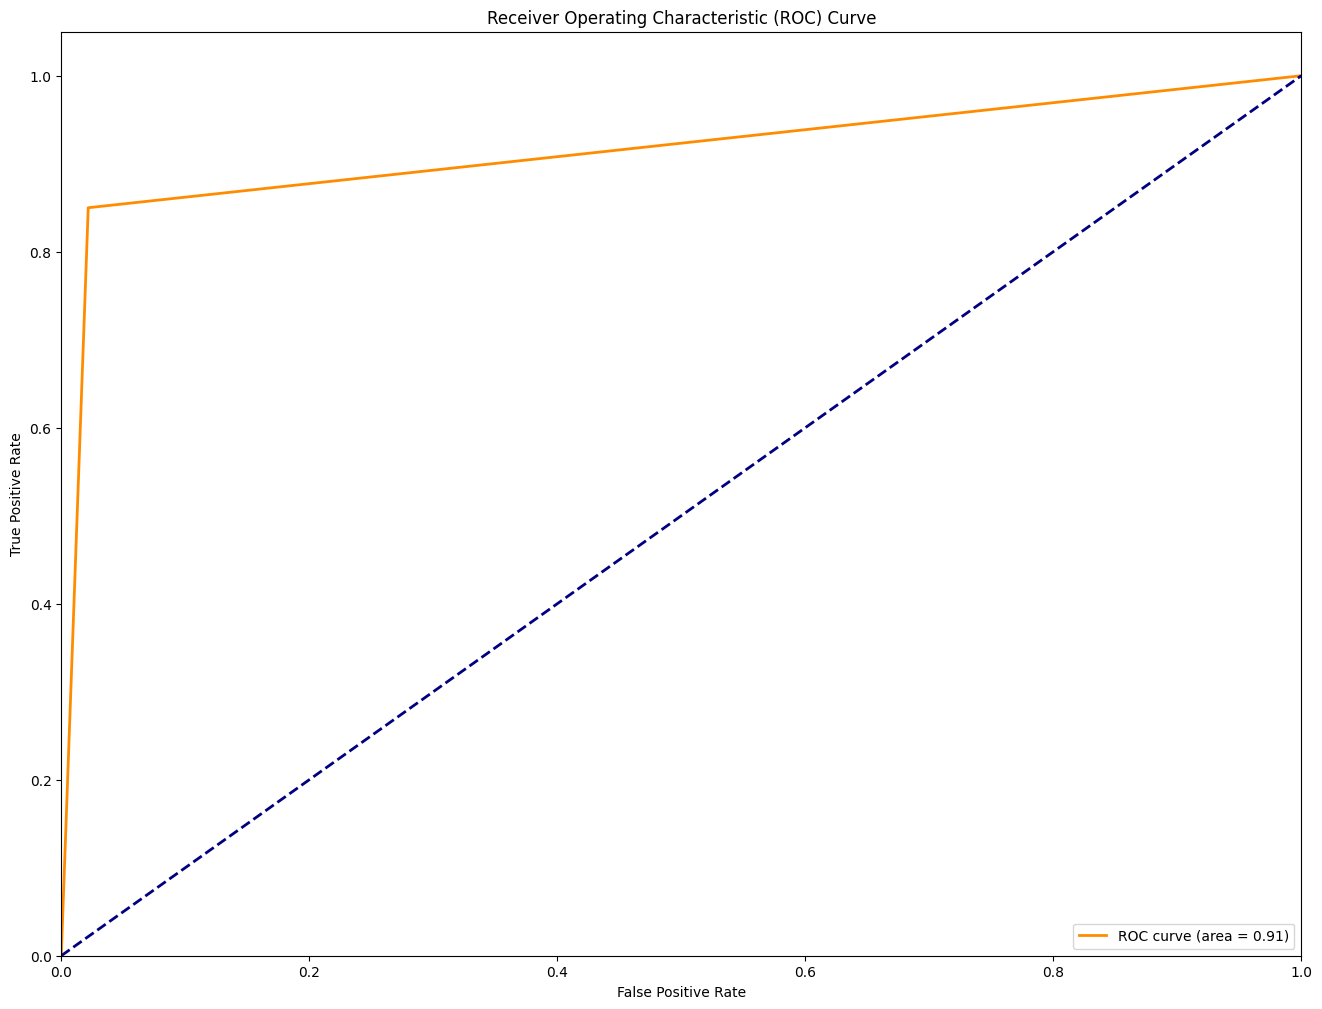

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Assuming you have already loaded and evaluated your model on the test data, and have y_test and y_pred_classes as defined in your code.

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_classes)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(16, 12))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
